In [1]:
#ツイートのテキスト読み込み
test = open("Datas/N_extract_tweet.txt", "r", encoding="utf-8")
lines = test.readlines()
test.close()
print(len(lines))

#ラベル読み込み
test = open("Datas/label.txt", "r", encoding="utf-8")
label = test.readlines()
test.close()
print(len(label))

10000
10000


In [3]:
print(lines[0:10])

['きょう 買い物 陸前高田 くん ピューン\n', '遠野物語 舞台\n', 'ょっよいしょっ\n', 'みんな ステッキ プレゼント\n', '君 ギブアップ\n', '岩手県 消防 表彰 受章 祝賀\n', '先日 開催 女子力 up 列車 様子 ネイルケア レッスン 作り バッチ 体験 久慈市 北 三陸\n', '震災 遠野 文化 何 の\n', 'ランチメニュー 実施中 写真 野菜 アサリ 旬 味覚 満載 メニュー 自慢\n', '教職員 辞令 交付\n']


In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.utils.np_utils import to_categorical

maxlen = 50
train = 0.7
validation = 0.1
max_words = 20000

# word indexを作成
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

data = pad_sequences(sequences, maxlen=maxlen)

# バイナリの行列に変換
categorical_labels = to_categorical(label)
labels = np.asarray(categorical_labels)

print("Shape of data tensor:{}".format(data.shape))
print("Shape of label tensor:{}".format(labels.shape))

# 行列をランダムにシャッフルする
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]


indices = [int(len(labels) * n) for n in [train, train + validation]]
x_train, x_validation, x_test = np.split(data, indices)
y_train, y_validation, y_test = np.split(labels, indices)

Using TensorFlow backend.


Found 18852 unique tokens.
Shape of data tensor:(10000, 50)
Shape of label tensor:(10000, 2)


In [3]:
tdata = lines[-10:]
tlabel = label[-10:]
print(tdata[-3])

sequences2 = tokenizer.texts_to_sequences(tdata)
test_data = pad_sequences(sequences2, maxlen=maxlen)

categorical_labels2 = to_categorical(tlabel)
test_labels = np.asarray(categorical_labels2)

アニメ映画 原案 特徴 猫 キャラクター 独特 ファンタジー 漫画家 展覧会 開催 繊細 色 鮮やか カラー イラスト 貴重 漫画 原稿 問合せ 岩手県立美術館 ima info



In [3]:
import keras.backend as K
from functools import partial

def normalize_y_pred(y_pred):
    return K.one_hot(K.argmax(y_pred), y_pred.shape[-1])

def class_true_positive(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label] + y_pred[:, class_label], 2), K.floatx())

def class_accuracy(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label], y_pred[:, class_label]),
                  K.floatx())

def class_precision(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_pred[:, class_label]) + K.epsilon())


def class_recall(class_label, y_true, y_pred):
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_true[:, class_label]) + K.epsilon())


def class_f_measure(class_label, y_true, y_pred):
    precision = class_precision(class_label, y_true, y_pred)
    recall = class_recall(class_label, y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def true_positive(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true + y_pred, 2),
                  K.floatx())


def micro_precision(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_pred) + K.epsilon())


def micro_recall(y_true, y_pred):
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_true) + K.epsilon())


def micro_f_measure(y_true, y_pred):
    precision = micro_precision(y_true, y_pred)
    recall = micro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def average_accuracy(y_true, y_pred):
    class_count = y_pred.shape[-1]
    class_acc_list = [class_accuracy(i, y_true, y_pred) for i in range(class_count)]
    class_acc_matrix = K.concatenate(class_acc_list, axis=0)
    return K.mean(class_acc_matrix, axis=0)


def macro_precision(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_precision(i, y_true, y_pred) for i in range(class_count)]) / K.cast(class_count, K.floatx())


def macro_recall(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_recall(i, y_true, y_pred) for i in range(class_count)]) / K.cast(class_count, K.floatx())


def macro_f_measure(y_true, y_pred):
    precision = macro_precision(y_true, y_pred)
    recall = macro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())

In [4]:
def weight_variable(shape):
    return K.truncated_normal(shape, stddev = 0.01)

In [5]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers.core import Dropout
from keras.optimizers import Adam
from keras.utils import plot_model

model = Sequential()
model.add(Embedding(20000, 50, input_length=maxlen))
model.add(Dropout(0.5))
model.add(LSTM(32, kernel_initializer=weight_variable))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
#opt = Adam(lr=1e-4, beta_1 = 0.9, beta_2 = 0.999)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc', macro_precision, macro_recall, macro_f_measure])
model.summary()
#plot_model(model, show_shapes=True, show_layer_names=True, to_file='N_method1_LSTM1024_model.png')

early_stopping = EarlyStopping(patience=0, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            1000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 1,010,690
Trainable params: 1,010,690
Non-trainable params: 0
_________________________________________________________________


In [6]:
history = model.fit(x_train, y_train,
                    epochs=100, 
                    batch_size=300,
                    validation_data=(x_validation, y_validation))#,
                    #callbacks=[early_stopping])

Train on 7000 samples, validate on 999 samples
Epoch 1/100
7000/7000 [==============================] - 4s 571us/step - loss: 0.6873 - acc: 0.6093 - macro_precision: 0.6325 - macro_recall: 0.6089 - macro_f_measure: 0.6199 - val_loss: 0.6673 - val_acc: 0.6336 - val_macro_precision: 0.6833 - val_macro_recall: 0.6487 - val_macro_f_measure: 0.6656
Epoch 2/100
7000/7000 [==============================] - 2s 282us/step - loss: 0.5983 - acc: 0.6921 - macro_precision: 0.7023 - macro_recall: 0.6950 - macro_f_measure: 0.6986 - val_loss: 0.5250 - val_acc: 0.7317 - val_macro_precision: 0.7534 - val_macro_recall: 0.7218 - val_macro_f_measure: 0.7373
Epoch 3/100
7000/7000 [==============================] - 2s 284us/step - loss: 0.4523 - acc: 0.7944 - macro_precision: 0.8008 - macro_recall: 0.7949 - macro_f_measure: 0.7978 - val_loss: 0.4806 - val_acc: 0.7518 - val_macro_precision: 0.7992 - val_macro_recall: 0.7387 - val_macro_f_measure: 0.7677
Epoch 4/100
7000/7000 [==============================] -

7000/7000 [==============================] - 2s 279us/step - loss: 0.0562 - acc: 0.9759 - macro_precision: 0.9758 - macro_recall: 0.9760 - macro_f_measure: 0.9759 - val_loss: 1.2383 - val_acc: 0.7588 - val_macro_precision: 0.7574 - val_macro_recall: 0.7573 - val_macro_f_measure: 0.7574
Epoch 29/100
7000/7000 [==============================] - 2s 286us/step - loss: 0.0507 - acc: 0.9759 - macro_precision: 0.9758 - macro_recall: 0.9759 - macro_f_measure: 0.9759 - val_loss: 1.2832 - val_acc: 0.7588 - val_macro_precision: 0.7576 - val_macro_recall: 0.7570 - val_macro_f_measure: 0.7573
Epoch 30/100
7000/7000 [==============================] - 2s 289us/step - loss: 0.0543 - acc: 0.9770 - macro_precision: 0.9770 - macro_recall: 0.9770 - macro_f_measure: 0.9770 - val_loss: 1.3422 - val_acc: 0.7588 - val_macro_precision: 0.7580 - val_macro_recall: 0.7592 - val_macro_f_measure: 0.7586
Epoch 31/100
7000/7000 [==============================] - 2s 282us/step - loss: 0.0517 - acc: 0.9747 - macro_prec

7000/7000 [==============================] - 2s 280us/step - loss: 0.0454 - acc: 0.9781 - macro_precision: 0.9783 - macro_recall: 0.9781 - macro_f_measure: 0.9782 - val_loss: 1.4504 - val_acc: 0.7477 - val_macro_precision: 0.7470 - val_macro_recall: 0.7455 - val_macro_f_measure: 0.7463
Epoch 56/100
7000/7000 [==============================] - 2s 281us/step - loss: 0.0415 - acc: 0.9787 - macro_precision: 0.9788 - macro_recall: 0.9786 - macro_f_measure: 0.9787 - val_loss: 1.5658 - val_acc: 0.7508 - val_macro_precision: 0.7497 - val_macro_recall: 0.7500 - val_macro_f_measure: 0.7499
Epoch 57/100
7000/7000 [==============================] - 2s 277us/step - loss: 0.0415 - acc: 0.9793 - macro_precision: 0.9792 - macro_recall: 0.9794 - macro_f_measure: 0.9793 - val_loss: 1.5599 - val_acc: 0.7538 - val_macro_precision: 0.7525 - val_macro_recall: 0.7528 - val_macro_f_measure: 0.7526
Epoch 58/100
7000/7000 [==============================] - 2s 280us/step - loss: 0.0416 - acc: 0.9800 - macro_prec

7000/7000 [==============================] - 2s 278us/step - loss: 0.0419 - acc: 0.9789 - macro_precision: 0.9789 - macro_recall: 0.9789 - macro_f_measure: 0.9789 - val_loss: 1.6614 - val_acc: 0.7407 - val_macro_precision: 0.7399 - val_macro_recall: 0.7376 - val_macro_f_measure: 0.7388
Epoch 83/100
7000/7000 [==============================] - 2s 281us/step - loss: 0.0407 - acc: 0.9794 - macro_precision: 0.9795 - macro_recall: 0.9795 - macro_f_measure: 0.9795 - val_loss: 1.8746 - val_acc: 0.7407 - val_macro_precision: 0.7397 - val_macro_recall: 0.7408 - val_macro_f_measure: 0.7402
Epoch 84/100
7000/7000 [==============================] - 2s 274us/step - loss: 0.0397 - acc: 0.9799 - macro_precision: 0.9799 - macro_recall: 0.9798 - macro_f_measure: 0.9798 - val_loss: 1.7228 - val_acc: 0.7357 - val_macro_precision: 0.7343 - val_macro_recall: 0.7349 - val_macro_f_measure: 0.7346
Epoch 85/100
7000/7000 [==============================] - 2s 276us/step - loss: 0.0387 - acc: 0.9809 - macro_prec

In [8]:
loss_and_metrics = model.evaluate(x_test, y_test)
print(loss_and_metrics)

2001/2001 [==============================] - 1s 311us/step
[0.4839130026111002, 0.7751124438674732, 0.7779187941658443, 0.7764930277094729, 0.7771566998714331]


In [11]:
classes = model.predict_classes(test_data, batch_size=10)
print(test_labels == classes)
print(classes)
print(tlabel)

False
[1 0 0 0 0 1 0 1 0 1]
['1\n', '0\n', '0\n', '0\n', '0\n', '0\n', '0\n', '1\n', '0\n', '1\n']


G:\ganda\conda\tensorflow_test\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  


In [32]:
print(tdata[0])

祝 成人 ドリンク 杯 無料 土日 期間 今年 新成人 ファースト ドリンク サービス 記念 瞬間 遠野 醸造 ビール 乾杯 詳細



In [8]:
model.save('N_method1_model_LSTM1024.h5')

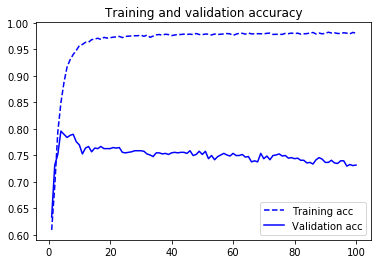

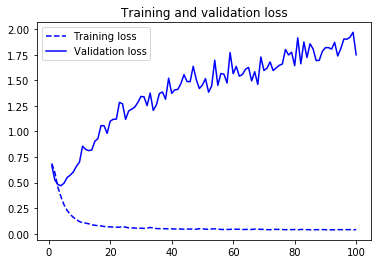

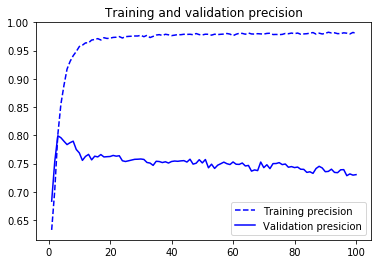

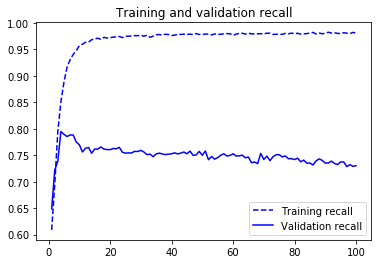

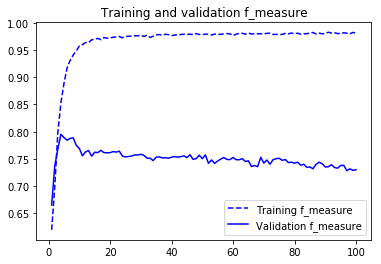

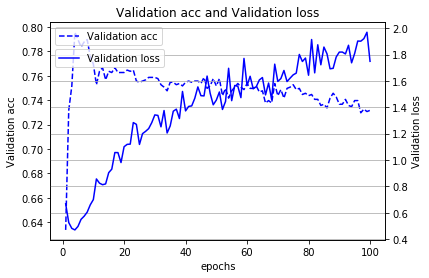

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['macro_precision']
val_precision = history.history['val_macro_precision']
recall = history.history['macro_recall']
val_recall = history.history['val_macro_recall']
f_measure = history.history['macro_f_measure']
val_f_measure = history.history['val_macro_f_measure']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig("RNN_tweet/Figs/N_method1/N_acc.png")

plt.figure()

plt.plot(epochs, loss, 'b--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
#plt.savefig("RNN_tweet/Figs/N_method1/N_loss.png")

plt.figure()

plt.plot(epochs, precision, 'b--', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation presicion')
plt.title('Training and validation precision')
plt.legend()
#plt.savefig("RNN_tweet/Figs/N_method1/N_precision.png")

plt.figure()

plt.plot(epochs, recall, 'b--', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
#plt.savefig("RNN_tweet/Figs/N_method1/N_recall.png")

plt.figure()

plt.plot(epochs, f_measure, 'b--', label='Training f_measure')
plt.plot(epochs, val_f_measure, 'b', label='Validation f_measure')
plt.title('Training and validation f_measure')
plt.legend()
#plt.savefig("RNN_tweet/Figs/N_method1/N_f_measure.png")

fig = plt.figure()

ax_acc = fig.add_subplot(111)
ax_acc.plot(epochs, val_acc, 'b--', label='Validation acc')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, fontsize=10)

ax_loss = ax_acc.twinx()
ax_loss.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend(bbox_to_anchor=(0, 0.9), loc='upper left', borderaxespad=0.5, fontsize=10)
plt.title('Validation acc and Validation loss')
ax_acc.set_xlabel('epochs')
ax_acc.set_ylabel('Validation acc')
ax_loss.grid(True)
ax_loss.set_ylabel('Validation loss')

#plt.savefig("RNN_tweet/Figs/N_method1/acc_loss.png")
plt.show()

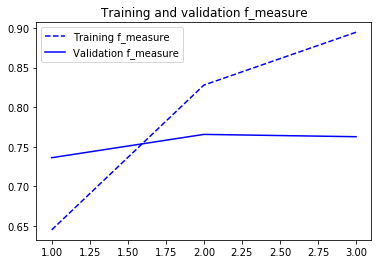

In [19]:
plt.plot(epochs, f_measure, 'b--', label='Training f_measure')
plt.plot(epochs, val_f_measure, 'b', label='Validation f_measure')
plt.title('Training and validation f_measure')
plt.legend()

plt.savefig("N_f_measure.png")
plt.show()

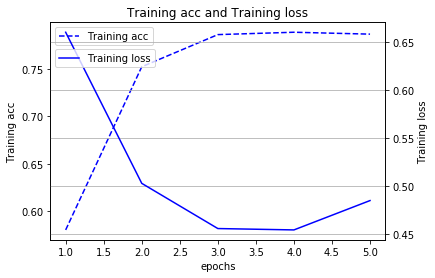

In [10]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)
ax_acc.plot(epochs, val_acc, 'b--', label='Training acc')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, fontsize=10)

ax_loss = ax_acc.twinx()
ax_loss.plot(epochs, val_loss, 'b', label='Training loss')
plt.legend(bbox_to_anchor=(0, 0.9), loc='upper left', borderaxespad=0.5, fontsize=10)
plt.title('Training acc and Training loss')
ax_acc.set_xlabel('epochs')
ax_acc.set_ylabel('Training acc')
ax_loss.grid(True)
ax_loss.set_ylabel('Training loss')

plt.show()